In [1]:
%cd /workspaces/segment_vasculature/models/

/workspaces/segment_vasculature/models


/usr/local/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: timothy-lindblom. Use `wandb login --relogin` to force relogin


True

In [3]:
import os
import cv2
from helpers.dataset_setup import TRAIN_FOLDER

def movie_maker(image_folder, video_name):
    images = [img for img in os.listdir(image_folder) if img.endswith(".tif")]
    frame = cv2.imread(os.path.join(image_folder, images[0]))
    height, width, layers = frame.shape

    video = cv2.VideoWriter(video_name, 0, 5, (width,height))

    for image in images:
        video.write(cv2.imread(os.path.join(image_folder, image)))

    cv2.destroyAllWindows()
    video.release()

# Get all folders in train/
names = os.listdir(TRAIN_FOLDER)
for i, name in enumerate(names):
    if name == "kidney_3_dense":
        continue
    image_folder = f'{TRAIN_FOLDER}/{name}/images'
    images = [img for img in os.listdir(image_folder) if img.endswith(".tif")]
    frame = cv2.imread(os.path.join(image_folder, images[0]))
    print(f"{name}: {frame.shape}")


kidney_1_dense: (1303, 912, 3)
kidney_1_voi: (1928, 1928, 3)
kidney_2: (1041, 1511, 3)
kidney_3_sparse: (1706, 1510, 3)


Code below is from: https://www.kaggle.com/code/aniketkolte04/sennet-hoa-seg-pytorch-attention-gated-unet/notebook

In [4]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from helpers.dataset_setup import CustomDataset, augment_image
from helpers.train_test import train_and_test
from torch.optim.lr_scheduler import ExponentialLR

In [5]:
image_folder = f'{TRAIN_FOLDER}/kidney_2/images/'
image_files = [os.path.join(image_folder, img) for img in os.listdir(image_folder) if img.endswith(".tif")]
image_files.sort()
labels_folder = f'{TRAIN_FOLDER}/kidney_2/labels/'
label_files = [os.path.join(labels_folder, img) for img in os.listdir(labels_folder) if img.endswith(".tif")]
label_files.sort()

# Test overfitting to see if my model can learn anything

In [6]:
N_IMAGES = 20
start_image = 580
image_files = image_files[start_image:(start_image+N_IMAGES)]
label_files = label_files[start_image:(start_image+N_IMAGES)]

In [7]:
train_image_files, val_image_files, train_mask_files, val_mask_files = train_test_split(
    image_files, label_files, test_size=0.1, random_state=42)

In [8]:
train_dataset = CustomDataset(train_image_files, train_mask_files, augmentation_transforms=augment_image, input_size=(512, 512))
val_dataset = CustomDataset(val_image_files, val_mask_files, augmentation_transforms=augment_image, input_size=(512, 512))

In [9]:
BATCH_SIZE = 1
train_dataloader= DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [10]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
device = get_default_device()
device

device(type='cuda')

In [11]:
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)
    elif isinstance(m, nn.BatchNorm2d):
        torch.nn.init.ones_(m.weight)
        torch.nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Linear):
        torch.nn.init.zeros_(m.bias)

class ConvBlock(nn.Module):
    def __init__(self,in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_channels),
            nn.GELU()
        )
        self.conv.apply(init_weights)

    def forward(self,x):
        x = self.conv(x)
        return x
    

class UpConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_channels),
            nn.GELU()
        )
        self.up.apply(init_weights)

    def forward(self, x):
        x = self.up(x)
        return x
    
class AttentionBlock(nn.Module):
    """Attention block with learnable parameters"""

    def __init__(self, F_g, F_l, n_coefficients):
        super(AttentionBlock, self).__init__()

        self.W_gate = nn.Sequential(
            nn.Conv2d(F_g, n_coefficients, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(n_coefficients)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, n_coefficients, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(n_coefficients)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(n_coefficients, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.GELU = nn.GELU()

    def forward(self, gate, skip_connection):

        g1 = self.W_gate(gate)
        x1 = self.W_x(skip_connection)
        psi = self.GELU(g1 + x1)
        psi = self.psi(psi)
        out = skip_connection * psi
        return out


class AttentionUNet(nn.Module):

    def __init__(self, img_ch=3, output_ch=1):
        super(AttentionUNet, self).__init__()

        self.MaxPool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.Conv1 = ConvBlock(img_ch, 64)
        self.Conv2 = ConvBlock(64, 128)
        self.Conv3 = ConvBlock(128, 256)
        self.Conv4 = ConvBlock(256, 512)
        self.Conv5 = ConvBlock(512, 1024)

        self.Up5 = UpConv(1024, 512)
        self.Att5 = AttentionBlock(F_g=512, F_l=512, n_coefficients=256)
        self.UpConv5 = ConvBlock(1024, 512)

        self.Up4 = UpConv(512, 256)
        self.Att4 = AttentionBlock(F_g=256, F_l=256, n_coefficients=128)
        self.UpConv4 = ConvBlock(512, 256)

        self.Up3 = UpConv(256, 128)
        self.Att3 = AttentionBlock(F_g=128, F_l=128, n_coefficients=64)
        self.UpConv3 = ConvBlock(256, 128)

        self.Up2 = UpConv(128, 64)
        self.Att2 = AttentionBlock(F_g=64, F_l=64, n_coefficients=32)
        self.UpConv2 = ConvBlock(128, 64)

        self.Conv = nn.Conv2d(64, output_ch, kernel_size=1, stride=1, padding=0)

    def forward(self, x):

        e1 = self.Conv1(x)

        e2 = self.MaxPool(e1)
        e2 = self.Conv2(e2)

        e3 = self.MaxPool(e2)
        e3 = self.Conv3(e3)

        e4 = self.MaxPool(e3)
        e4 = self.Conv4(e4)

        e5 = self.MaxPool(e4)
        e5 = self.Conv5(e5)

        d5 = self.Up5(e5)

        s4 = self.Att5(gate=d5, skip_connection=e4)
        d5 = torch.cat((s4, d5), dim=1) 
        d5 = self.UpConv5(d5)

        d4 = self.Up4(d5)
        s3 = self.Att4(gate=d4, skip_connection=e3)
        d4 = torch.cat((s3, d4), dim=1)
        d4 = self.UpConv4(d4)

        d3 = self.Up3(d4)
        s2 = self.Att3(gate=d3, skip_connection=e2)
        d3 = torch.cat((s2, d3), dim=1)
        d3 = self.UpConv3(d3)

        d2 = self.Up2(d3)
        s1 = self.Att2(gate=d2, skip_connection=e1)
        d2 = torch.cat((s1, d2), dim=1)
        d2 = self.UpConv2(d2)

        out = self.Conv(d2)

        return out

In [12]:
class FocalLoss(nn.modules.loss._WeightedLoss):

    def __init__(self, gamma=0, size_average=None, ignore_index=-100,
                 reduce=None, balance_param=1.0):
        super(FocalLoss, self).__init__(size_average)
        self.gamma = gamma
        self.size_average = size_average
        self.ignore_index = ignore_index
        self.balance_param = balance_param

    def forward(self, input, target):
        
        assert len(input.shape) == len(target.shape)
        assert input.size(0) == target.size(0)
        assert input.size(1) == target.size(1)

        logpt = - F.binary_cross_entropy_with_logits(input, target)
        pt = torch.exp(logpt)

        focal_loss = -((1 - pt) ** self.gamma) * logpt
        balanced_focal_loss = self.balance_param * focal_loss
        return balanced_focal_loss

In [13]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1): 
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice
    
def dice_coeff(prediction, target):

    mask = np.zeros_like(prediction)
    mask[prediction >= 0.5] = 1

    inter = np.sum(mask * target)
    union = np.sum(mask) + np.sum(target)
    epsilon = 1e-6
    result = np.mean(2 * inter / (union + epsilon))
    return result

In [14]:
dataloaders = {
    'train': train_dataloader,
    'val': val_dataloader
}

In [15]:
epochs = 200
lr = 1e-4
mom = 0
damp = 0
decay = 0
nesterov = False
lr_decay = 0.99
grad_clip_bound = .1

In [16]:
run = wandb.init(
    project="custom_seg_vasculature",
    config={
        "architechture": "CNN",
        "optimizer": "SGD",
        "learning_rate": lr,
        "momentum": mom,
        "damp": damp,
        "decay": decay,
        "epochs": epochs,
        "batch_size": BATCH_SIZE,
        "loss_function": "dice",
        "nesterov": nesterov,
        "scheduler": "ExpLR",
        "gamma": lr_decay,
        "gradient_clipping": "True",
        "gradient_clip_bound": grad_clip_bound,
        #"norm_grad_clip": "True",
        "kaiming_init_conv_blocks": "True",
    }
)

In [17]:
def train():
    model = AttentionUNet()
    for n, p in model.named_parameters():
        if "Conv1" in n:
            p.register_hook(lambda grad: torch.clamp(grad, -grad_clip_bound*10, grad_clip_bound*10))
        else:
            p.register_hook(lambda grad: torch.clamp(grad, -grad_clip_bound, grad_clip_bound))

    #model.load_state_dict(torch.load('custom_trained_75.pth'))  
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=mom, dampening=damp, weight_decay=decay, nesterov=nesterov)
    scheduler = ExponentialLR(optimizer, gamma=lr_decay)
    #torch.optim.Adam(model.parameters())
    criterion = DiceLoss()
    run.watch(models=model, log="all", log_freq=N_IMAGES*2/BATCH_SIZE)
    trained_model, train_epoch_losses, test_epoch_losses = train_and_test(model, dataloaders, optimizer, criterion, num_epochs=epochs, show_images=True, scheduler=scheduler, max_norm=grad_clip_bound)
    return trained_model, train_epoch_losses, test_epoch_losses

trained_model, train_epoch_losses, test_epoch_losses = train()
#torch.save(trained_model.state_dict(), 'lower_learning_rate_100.pth')

Epoch 1/200
----------
Input: torch.Size([1, 3, 512, 512])
Output: torch.Size([1, 1, 512, 512])
Mask: torch.Size([1, 512, 512])
Input: torch.Size([1, 3, 512, 512])
Output: torch.Size([1, 1, 512, 512])
Mask: torch.Size([1, 512, 512])
Input: torch.Size([1, 3, 512, 512])
Output: torch.Size([1, 1, 512, 512])
Mask: torch.Size([1, 512, 512])
Input: torch.Size([1, 3, 512, 512])
Output: torch.Size([1, 1, 512, 512])
Mask: torch.Size([1, 512, 512])
Input: torch.Size([1, 3, 512, 512])
Output: torch.Size([1, 1, 512, 512])
Mask: torch.Size([1, 512, 512])
Input: torch.Size([1, 3, 512, 512])
Output: torch.Size([1, 1, 512, 512])
Mask: torch.Size([1, 512, 512])
Input: torch.Size([1, 3, 512, 512])
Output: torch.Size([1, 1, 512, 512])
Mask: torch.Size([1, 512, 512])
Input: torch.Size([1, 3, 512, 512])
Output: torch.Size([1, 1, 512, 512])
Mask: torch.Size([1, 512, 512])
Input: torch.Size([1, 3, 512, 512])
Output: torch.Size([1, 1, 512, 512])
Mask: torch.Size([1, 512, 512])
Input: torch.Size([1, 3, 512, 51

KeyboardInterrupt: 

In [18]:
wandb.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Turns out that model fails to overfit on just training data. This suggests a bug somewhere or issues with the data representation or just too high learning rate as I once saw the model go from ok scores to horrible.

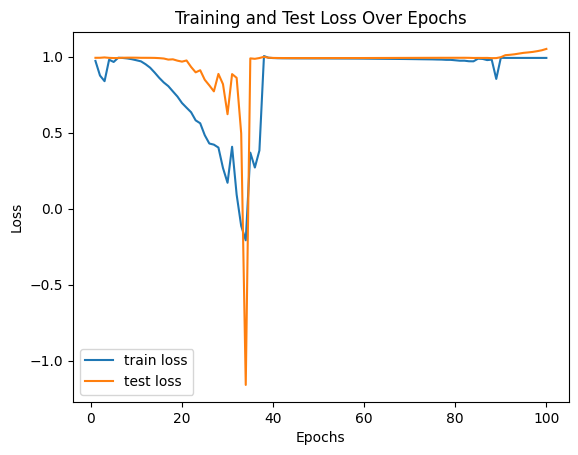

In [ ]:
train_plot, = plt.plot(range(1, len(train_epoch_losses) + 1), train_epoch_losses, label='train loss')
test_plot, = plt.plot(range(1, len(test_epoch_losses) + 1), test_epoch_losses, label='test loss')
plt.legend(handles=[train_plot, test_plot])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Epochs')
plt.show() 

## Visual inspection the custom trained model.

In [ ]:
def eval_model(model):  
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

In [ ]:
def eval():
    model = AttentionUNet()
    model.load_state_dict(torch.load('custom_trained_75.pth'))
    optimizer = torch.optim.Adam(model.parameters(), lr = 1e5)
    criterion = DiceLoss()